# Chargepoint Sessions Data Analysis

This notebook performs some analysis on the electric vehicle chargpeoint sessions data from Dundee City Council.

The anonymous data contains details of all charging sessions on the public network hosted by the Council. We can use Pandas to answer some questions about how people use the chargers such as;

* Which chargepoint sites are most popular?
* How much energy has been delivered to vehicles?
* What times of day are most popular for charging your car?

This notebook is written in python only.

## Preparing the Environment

Before we can get started install and import the python modules that we'll be using in this notebook. 

In [2]:
# Install the CKAN API
!pip install ckanapi

  Running setup.py bdist_wheel for ckanapi ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/33/59/4e/bc1f33e8861c8725b34d1228e7fc6dbd40cd267733c841325f
  Running setup.py bdist_wheel for docopt ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/b2/16/5f/c33a2bb5f2dce71205f8e65cbfd05647d79d441282be31fd82
Successfully built ckanapi docopt


In [3]:
# Import modules
from pandas import *
from datetime import datetime
import calendar
import requests, ckanapi
import seaborn as sns
from matplotlib import pyplot


Configure the [CKAN API](https://github.com/ckan/ckanapi) to connect to [data.dundeecity.gov.uk](https://data.dundeecity.gov.uk), Dundee's CKAN instance. 

In [4]:
dd = ckanapi.RemoteCKAN('https://data.dundeecity.gov.uk')

## Getting the Data

We'll get the charging sessoin data from the Dundee datastore using the [datastore API](http://docs.ckan.org/en/latest/maintaining/datastore.html#the-datastore-api), and then load it into a [DataFrame](https://pandas.pydata.org/pandas-docs/), which lets us analyse the dataset in pandas.


In [5]:
# Download sessions using the CKAN Datastore API
charge_sessions_ds = dd.action.datastore_search(resource_id='d748579a-f05f-47e6-a76b-e76d1e2e9589', limit=20000)

In [6]:
# Convert to Pandas Dataframe
df = pandas.DataFrame(charge_sessions_ds['records'])
df[1:10] # Print the first 10 rows.

,CP ID,Charging event,Connector,Cost,End Date,End Time,Group,Model,Site,Start Date,Start Time,Total kWh,_id
1,NaN,4032912,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT 7kW Dual Outlet,,2017-01-12T00:00:00,12:09,NaN,2
2,50269.0,4032900,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT 7kW Dual Outlet,"Housing Office East, Dundee",2017-01-12T00:00:00,12:07,NaN,3
3,50523.0,4032891,1,NaN,None,,APT Controls; CYC; Dundee City Council; Charge...,APT 7kW Dual Outlet,"Marchbanks, Dundee",2017-01-12T00:00:00,12:03,NaN,4
4,50338.0,4032879,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,"Social Work Building, Jack Martin Way, Dundee",2017-01-12T00:00:00,12:00,NaN,5
5,50240.0,4032877,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT 7kW Dual Outlet,"Gellatly Street Car Park, Dundee",2017-01-12T00:00:00,11:59,NaN,6
6,51201.0,4032866,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT 7kW Single Outlet,"Dundee House, Dundee",2017-01-12T00:00:00,11:56,NaN,7
7,50675.0,4032809,1,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT 7kW Dual Outlet,"Olympia Multi-Storey Car Park, Dundee",2017-01-12T00:00:00,11:42,NaN,8
8,50267.0,4032762,2,NaN,None,,APT Controls; CYC; Dundee City Council; Charge...,APT 7kW Dual Outlet,"Social Work Building, Jack Martin Way, Dundee",2017-01-12T00:00:00,11:28,NaN,9
9,50692.0,4032755,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,"Dundee Ice Arena, Dundee",2017-01-12T00:00:00,11:25,NaN,10


# Which are the busiest charging sites?

Where are the most popular chargepoints?

>Note this data includes both public chargepoints (like the Queen Street Car Park), and private chargepoints used by the Council such as the public works department on Clepington Road.

### By Number of Charging Sessions

In [7]:
df.groupby(['Site']).size().sort_values(ascending=False)

Site
Public Works Dept, Clepington Rd. Dundee         3332
Queen Street Car Park, Broughty Ferry, Dundee    2600
Dundee Ice Arena, Dundee                         2102
Greenmarket Multi Car Park, Dundee               1126
Dundee House, Dundee                              866
Gellatly Street Car Park, Dundee                  788
Social Work Building, Jack Martin Way, Dundee     553
Whitfield Centre, Dundee                          466
Janet Brougham House, Dundee                      378
Housing Office East, Dundee                       337
Olympia Multi-Storey Car Park, Dundee             316
South Tay Street                                  292
Marchbanks, Dundee                                272
Dock Street, Dundee                               271
Brington Place Sheltered Housing, Dundee          257
Trades Lane                                       240
Sinclair Street                                   229
Nethergate, Dundee                                189
Housing Office West, Du

### By total power consumption

Sometimes if a session doesn't end correctly there's no power consumption recorded.  To calculate the total we have to filter out those values.

In [8]:
# Total power usage - group by session. 
sessions_by_site=df[df['Total kWh'].notnull()].groupby(['Site'])['Total kWh'].sum()
sessions_by_site.sort_values(ascending=False)

Site
Public Works Dept, Clepington Rd. Dundee         24092.007
Dundee Ice Arena, Dundee                         22466.537
Queen Street Car Park, Broughty Ferry, Dundee    18715.366
Greenmarket Multi Car Park, Dundee               12527.712
Gellatly Street Car Park, Dundee                  5252.037
Social Work Building, Jack Martin Way, Dundee     4076.366
Dundee House, Dundee                              3404.880
South Tay Street                                  2921.838
Olympia Multi-Storey Car Park, Dundee             2597.180
Janet Brougham House, Dundee                      2419.990
Balunie Drive, Dundee                             2213.070
Whitfield Centre, Dundee                          2194.090
Sinclair Street                                   2131.513
Housing Office East, Dundee                       2117.770
Marchbanks, Dundee                                2091.560
Nethergate, Dundee                                1662.660
Dock Street, Dundee                               1

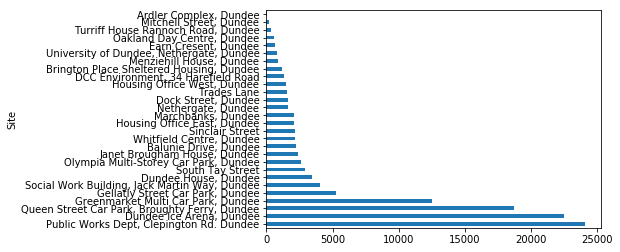

In [9]:
%matplotlib inline
sessions_by_site.sort_values(ascending=False).plot(x='Site',y='Total kWh', kind='barh')

## Session Dates and Times

What about days and times;

* What times are busiest for charging? 
* Does the busy time vary by location?


The data is delivered with a separate date and time column, but we can use the `to_datetime` function to convert this into a datetime object.  

In [10]:
# Create a datetime column for start of session (join the start date and start time string columns)
df['StartDateTime'] = pandas.to_datetime(df['Start Date'].str.slice(0,10) + ' '+ df['Start Time'],format="%Y-%m-%d %H:%M")
df = df.set_index(pandas.DatetimeIndex(df['StartDateTime']))
df[0:5]

,CP ID,Charging event,Connector,Cost,End Date,End Time,Group,Model,Site,Start Date,Start Time,Total kWh,_id,StartDateTime
StartDateTime,,,,,,,,,,,,,,
2017-01-12 12:09:00,NaN,4032911,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,,2017-01-12T00:00:00,12:09,NaN,1,2017-01-12 12:09:00
2017-01-12 12:09:00,NaN,4032912,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT 7kW Dual Outlet,,2017-01-12T00:00:00,12:09,NaN,2,2017-01-12 12:09:00
2017-01-12 12:07:00,50269.0,4032900,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT 7kW Dual Outlet,"Housing Office East, Dundee",2017-01-12T00:00:00,12:07,NaN,3,2017-01-12 12:07:00
2017-01-12 12:03:00,50523.0,4032891,1,NaN,None,,APT Controls; CYC; Dundee City Council; Charge...,APT 7kW Dual Outlet,"Marchbanks, Dundee",2017-01-12T00:00:00,12:03,NaN,4,2017-01-12 12:03:00
2017-01-12 12:00:00,50338.0,4032879,2,NaN,None,,APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,"Social Work Building, Jack Martin Way, Dundee",2017-01-12T00:00:00,12:00,NaN,5,2017-01-12 12:00:00


In [11]:
df.resample('W').size()

StartDateTime
2017-01-15     587
2017-01-22       0
2017-01-29       0
2017-02-05       0
2017-02-12     463
2017-02-19       0
2017-02-26       0
2017-03-05       0
2017-03-12     477
2017-03-19       0
2017-03-26       0
2017-04-02       0
2017-04-09     159
2017-04-16     321
2017-04-23       0
2017-04-30       0
2017-05-07       0
2017-05-14     460
2017-05-21       0
2017-05-28       0
2017-06-04       0
2017-06-11     573
2017-06-18       0
2017-06-25       0
2017-07-02       0
2017-07-09     191
2017-07-16     347
2017-07-23       0
2017-07-30       0
2017-08-06       0
2017-08-13     520
2017-08-20       0
2017-08-27       0
2017-09-03       0
2017-09-10     329
2017-09-17     986
2017-09-24    1156
2017-10-01    1017
2017-10-08       0
2017-10-15     983
2017-10-22    1168
2017-10-29    1176
2017-11-05     345
2017-11-12     503
2017-11-19    1253
2017-11-26    1222
2017-12-03     780
2017-12-10     329
2017-12-17     157
Freq: W-SUN, dtype: int64

When resampling to show the count of sessions per week above you can see there's a problem with some of the dates.  This data should be for September to December 2017.

In [12]:
df.groupby([df.index.hour]).size()

StartDateTime
0      276
1      318
2      223
3      182
4      146
5      132
6      192
7      452
8      618
9      867
10     965
11    1155
12    1361
13    1206
14    1113
15    1124
16    1021
17     704
18     532
19     539
20     524
21     890
22     470
23     492
dtype: int64

Add columns to the data frame for the day of week the session was started and also the hour of the day. 

In [13]:
df['DayofWeek']=df.index.dayofweek
df['StrDayofWeek']= df.index.weekday_name
df['StartHour'] = df.index.hour

Charting the time of day to see when most sessions are started. 

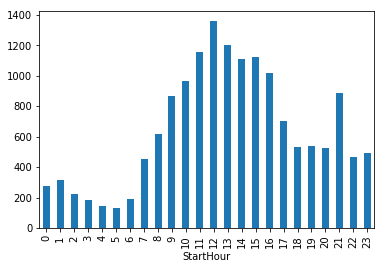

In [14]:
df.groupby(['StartHour']).size().plot(kind='bar')

Are there patterns of busy times? Does this vary by day of week and by chargepoint type (e.g. Rapid Chargers/Fast Chargers)

In [15]:
rapid_sessions = df[df['Model'].str.contains("Rapid")].pivot_table(index=['StrDayofWeek'],columns='StartHour',values='Charging event',aggfunc='count')
rapid_sessions = rapid_sessions.reindex_axis(calendar.day_name, axis=0)
fast_sessions = df[~df['Model'].str.contains("Rapid")].pivot_table(index=['StrDayofWeek'],columns='StartHour',values='Charging event',aggfunc='count')

fast_sessions = fast_sessions.reindex_axis(calendar.day_name, axis=0)

fast_sessions

StartHour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
StrDayofWeek,,,,,,,,,,,,,,,,,,,,,
Monday,8.0,3.0,4.0,5.0,2.0,2.0,7.0,17.0,51.0,76.0,...,86.0,113.0,105.0,42.0,32.0,19.0,15.0,71.0,8.0,26.0
Tuesday,6.0,4.0,1.0,1.0,2.0,NaN,5.0,20.0,53.0,70.0,...,108.0,105.0,96.0,45.0,22.0,21.0,15.0,79.0,6.0,20.0
Wednesday,3.0,NaN,1.0,NaN,3.0,NaN,1.0,24.0,53.0,80.0,...,104.0,115.0,76.0,47.0,15.0,21.0,12.0,72.0,6.0,15.0
Thursday,4.0,2.0,3.0,1.0,4.0,NaN,5.0,21.0,48.0,59.0,...,71.0,114.0,87.0,47.0,24.0,18.0,17.0,62.0,8.0,18.0
Friday,4.0,1.0,1.0,2.0,NaN,NaN,1.0,20.0,65.0,73.0,...,97.0,99.0,74.0,58.0,21.0,23.0,11.0,64.0,7.0,16.0
Saturday,5.0,3.0,3.0,6.0,2.0,6.0,7.0,16.0,25.0,55.0,...,65.0,65.0,47.0,33.0,25.0,19.0,20.0,68.0,9.0,16.0
Sunday,2.0,7.0,NaN,5.0,1.0,3.0,3.0,14.0,23.0,38.0,...,56.0,52.0,52.0,34.0,16.0,16.0,16.0,56.0,10.0,25.0


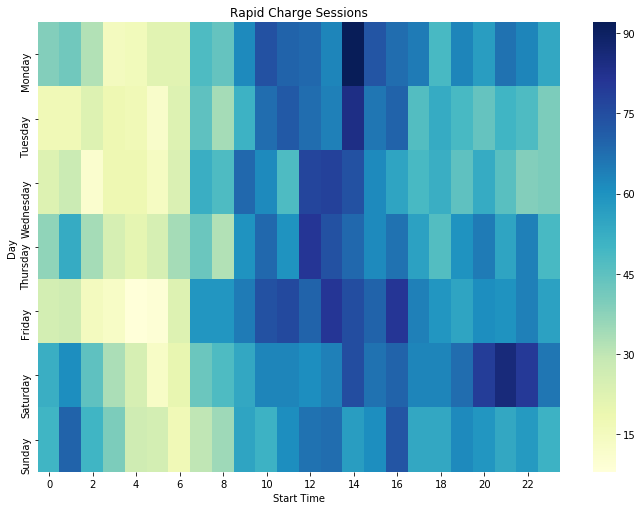

In [16]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.heatmap(rapid_sessions, ax=ax,xticklabels=2 , cmap="YlGnBu")
ax.set_title("Rapid Charge Sessions")
ax.set_xlabel("Start Time")
ax.set_ylabel("Day")
fig.savefig("SessionHeatMap_rapid.png")

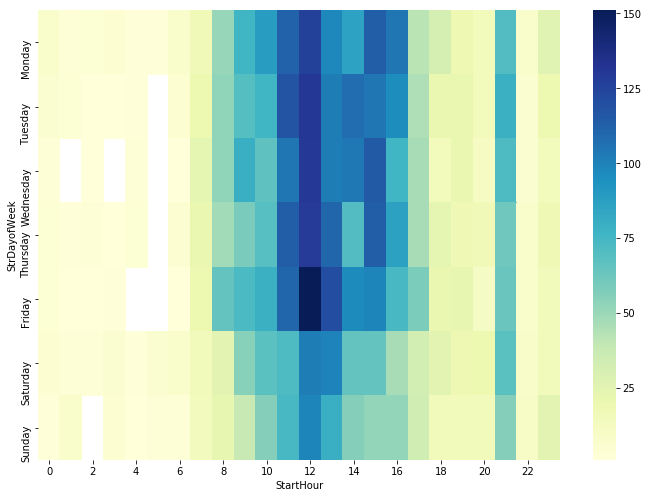

In [17]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.heatmap(fast_sessions, ax=ax,xticklabels=2,cmap='YlGnBu' )
fig.savefig("SessionHeatMap_fast.png")

![data.dundeecity.gov.uk](https://data.dundeecity.gov.uk/uploads/admin/2017-09-21-173807.593429Footer3EuroScot.png) ![Smart Cities Scotland](https://data.dundeecity.gov.uk/uploads/admin/2017-09-21-173808.054196Footer2SmartCities.png)